In [1]:
import numpy as np
import pandas as pd
import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### Data exploration

Nb samples:  3163
Nb chanels in data_cube:  11

Shape of 2 random samples: 
     sample 1:  (11, 44, 42)
     sample 2:  (11, 67, 74)
Nb categories:  8
Categories:  ['zinc', 'copper', 'brass', 'nickel', 'aluminium', 'pcb', 'painted', 'rubber']
Catogories to int:  {'zinc': 0, 'copper': 1, 'brass': 2, 'nickel': 3, 'aluminium': 4, 'pcb': 5, 'painted': 6, 'rubber': 7}


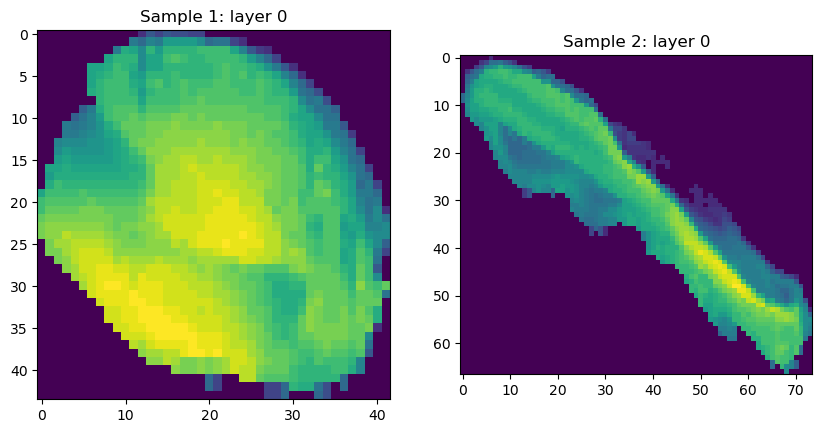

In [2]:
pickle_path = "data\original\dataset_3d_vnir_xrt.pkl"



df = pd.read_pickle(pickle_path)

print("Nb samples: ",len(df))
print("Nb chanels in data_cube: ",len(df["data_cube"][0]))
print("")
print("Shape of 2 random samples: ")
s1, s2 = random.choice(range(len(df))), random.choice(range(len(df)))
print("     sample 1: ",df["data_cube"][s1].shape)
print("     sample 2: ",df["data_cube"][s2].shape)
print("Nb categories: ",len(df["class"].unique()))
classes = df["class"].unique().tolist()
print("Categories: ",classes)
print("Catogories to int: ",{classes[i]:i for i in range(len(classes))})

plt.subplots(1,2,figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(df["data_cube"][s1][0])
plt.title("Sample 1: layer 0")
plt.subplot(1,2,2)
plt.imshow(df["data_cube"][s2][0])
plt.title("Sample 2: layer 0")

pi_data_dict = {0: "3D",
                1: "VNIR 1",
                2: "VNIR 2",
                3: "VNIR 3",
                4: "VNIR 4",
                5: "VNIR 5",
                6: "VNIR 6",
                7: "VNIR 7",
                8: "VNIR 8",
                9: "XRT 1",
                10: "XRT 2"}


### Creation of a dataset class

In [3]:
class PickItDataset(Dataset):    
    def __init__(self, pickle_path, transform=None,train = True, seed = 42):
        data = pd.read_pickle(pickle_path)
        data["cube"] = data["data_cube"].apply(lambda x: x.astype(np.float32))
        cube = data["cube"]
        mask = data["masks"]
        random.seed(seed)
        test_indices = random.sample(range(0, len(data)), int(len(data) * 0.2))
        if train:
            cube = cube.drop(test_indices).reset_index(drop=True)
            mask = mask.drop(test_indices).reset_index(drop=True)
            data = data.drop(test_indices).reset_index(drop=True)
        else:
            cube = cube.iloc[test_indices].reset_index(drop=True)
            mask = mask.iloc[test_indices].reset_index(drop=True)
            data = data.iloc[test_indices].reset_index(drop=True)
        self.data = cube
        self.masks = mask
        self.labels = data["class"].apply(lambda x: classes.index(x))
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            index = index.tolist()

        data = torch.from_numpy(self.data[idx])
        mask = torch.tensor(self.masks[idx])
        label = self.labels[idx]

        sample = {"data": data,"mask":mask, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


### Definition of the transforms

In [4]:
class Rescale(object):
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        data, mask ,label = sample["data"], sample["mask"],sample["label"]
        data = transforms.Resize(self.scale)(data)
        mask = transforms.Resize(self.scale)(mask.unsqueeze(0)).squeeze(0)
        return {"data": data,"mask":mask ,"label": label}


class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        data, mask, label = sample["data"], sample["mask"], sample["label"]
        if random.random() < self.p:
            data = transforms.RandomHorizontalFlip(p=1)(data)
            mask = transforms.RandomHorizontalFlip(p=1)(mask)
        return {"data": data,"mask":mask ,"label": label}

class RandomVerticalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        data, mask ,label = sample["data"], sample["mask"],sample["label"]
        if random.random() < self.p:
            data = transforms.RandomVerticalFlip(p=1)(data)
            mask = transforms.RandomVerticalFlip(p=1)(mask)
        return {"data": data,"mask":mask ,"label": label}

class Normalize(object):
    def __call__(self, sample):
        data, mask, label = sample["data"], sample["mask"], sample["label"]
        mean = torch.mean(data)
        std = torch.std(data)
        data = transforms.Normalize(mean,std)(data)
        return {"data": data,"mask":mask ,"label": label}
    


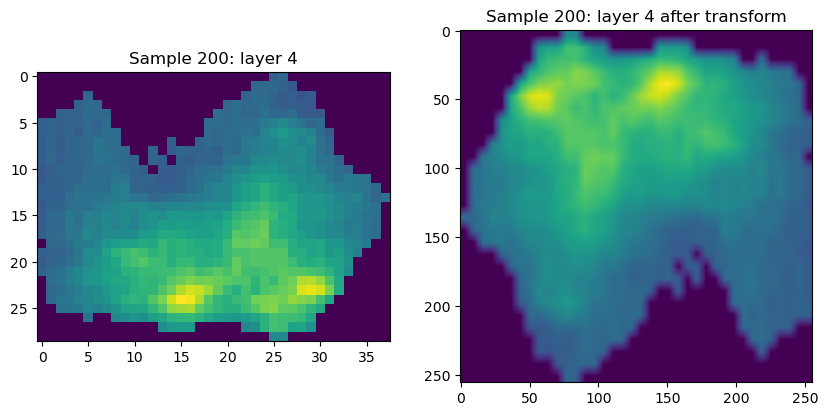

In [5]:
tr_demo = transforms.Compose([Rescale((256,256)),
                            RandomHorizontalFlip(1),
                            RandomVerticalFlip(1),
                            Normalize()])

def plot_transform(pickle_path, tr_demo, index=200, layer=0):
    demo = PickItDataset(pickle_path, transform=None)
    demo_tr = PickItDataset(pickle_path, transform=tr_demo)

    plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(demo[index]["data"][layer])
    plt.title("Sample "+str(index)+": layer "+str(layer))
    plt.subplot(1, 2, 2)
    plt.imshow(demo_tr[index]["data"][layer])
    plt.title("Sample "+str(index)+": layer "+str(layer)+" after transform")
    plt.show()
    
plot_transform(pickle_path, tr_demo, index=200, layer=4)


### loadind the dataset, applying the transforms and creating the dataloader

In [6]:
new_scale = (256, 256)
p_flip = 0.5
batch_size = 8
num_workers = 0
seed = 42

tr_train = transforms.Compose([Rescale(new_scale),RandomHorizontalFlip(p_flip),RandomVerticalFlip(p_flip),Normalize()])
tr_test = transforms.Compose([Rescale(new_scale),Normalize()])

trainset = PickItDataset(pickle_path, transform=tr_train,train = True, seed = seed)
testset = PickItDataset(pickle_path, transform=tr_test,train = False, seed = seed)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [7]:
print(next(iter(trainloader))["data"].shape)
print(next(iter(trainloader))["mask"].shape)
print(next(iter(trainloader))["label"])

torch.Size([8, 11, 256, 256])
torch.Size([8, 256, 256])
tensor([5, 1, 0, 3, 5, 2, 2, 4])


### CNN

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(11, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CNN()


### Loss function and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train CNN

In [10]:
nb_epochs = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
losses = []
for epoch in range(nb_epochs):
    losses_epoch = []
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data["data"].to(device), data["label"].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses_epoch.append(loss.item())
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/100))
            running_loss = 0.0
    losses.append(losses_epoch)


C:\Users\lambe\AppData\Local\Temp\ipykernel_28652\3282826019.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


[1,   100] loss: 1.611
[1,   200] loss: 1.140


KeyboardInterrupt: 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data["data"].to(device), data["label"].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)*batch_size} test images: {100 * correct / total} %')

Accuracy of the network on the 632 test images: 87.81645569620254 %


In [ ]:
import plotly.graph_objs as go
import plotly.graph_objects as go


df = pd.read_pickle('data\original\dataset_3d_vnir_xrt.pkl')
def plot_mesh(df, index=0):
    data = df["data_cube"][index][0]
    data = np.pad(data, (3, 3), mode='constant', constant_values=(0, 0))
    x = np.arange(0, data.shape[0], 1)
    y = np.arange(0, data.shape[1], 1)
    mesh = go.Surface(x=x, y=y, z=data, colorscale="Viridis")
    fig = go.Figure(data=[mesh])
    fig.show()
    
plot_mesh(df, index=10)
